In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import os
from glob import glob
import json
import h5py
from scipy import ndimage
from tqdm import tqdm
import pandas as pd

from infer_sociohydro2D import *

# Test on simulation data

In [ ]:
parent_folder = "/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro"

# fipy solver data
datafolder = "2024-06-19_schelling2D2S_fipy"

folder = os.path.join(parent_folder, datafolder)

datafile = glob(os.path.join(folder, "*hdf5"))[0]
paramfile = glob(os.path.join(folder, "*json"))[0]

with open(paramfile, "r") as p:
    params = json.load(p)

with h5py.File(datafile, "r") as d:
    xx = np.unique(d["common"]["x"][()])
    yy = np.unique(d["common"]["y"][()])
    ϕ1 = np.zeros((params["nt"]+1, params["nx"], params["ny"]))
    ϕ2 = np.zeros((params["nt"]+1, params["nx"], params["ny"]))
    tt = np.zeros(params["nt"]+1)
    for kidx, key in enumerate(list(d.keys())[1:]):
        ϕ1[kidx] = np.reshape(d[key]["phi1"][()], (params["nx"], params["ny"]))
        ϕ2[kidx] = np.reshape(d[key]["phi2"][()], (params["nx"], params["ny"]))
        tt[kidx] = d[key]["t"][()]

nonzero_idx = np.where(ϕ1[:, 0, 0])[0]
ϕ1 = ϕ1[nonzero_idx]
ϕ2 = ϕ2[nonzero_idx]
tt = tt[nonzero_idx]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
ax[0].pcolormesh(xx, yy, ϕ1[-1], cmap="Blues", vmin=0.1, vmax=0.4)
ax[0].set_aspect(1)
ax[1].pcolormesh(xx, yy, ϕ2[-1], cmap="Reds", vmin=0.1, vmax=0.4)
ax[1].set_aspect(1)



In [ ]:
inferer = SociohydroInfer2D(ϕ1[100:-1], ϕ2[100:-1], xx, yy, tt[100:-1])

In [ ]:
T = params["temp"]
Γ = params["gamma"]
k11 = 1
k22 = 1
k12 = params["kp"] - params["km"]
k21 = params["kp"] + params["km"]
nu = params["nu"]

coeffsA_true = np.array([T, -k11, -k12, -Γ, 0,        0, 0])
coeffsB_true = np.array([T, -k22, -k21, -Γ, k22 * nu, 0, 0])

In [ ]:
train_pct = 0.5
fig, ax = plt.subplots(dpi=144, figsize=(4, 2))
axp = ax.inset_axes([1.2, 0, 0.2, 1])
pAs = []
pBs = []
for i in range(100):
    fitA, fitB, pA, pB = inferer.fit(train_pct)
    ax.plot(np.arange(len(fitA.coef_)) - 0.25, fitA.coef_, "C0.", alpha=0.1)
    ax.plot(np.arange(len(fitB.coef_)) + 0.25, fitB.coef_, "C3.", alpha=0.1)
    pAs.append(pA)
    pBs.append(pB)
    # axp.plot([0, 1], [pA, pB], 'k.', alpha=0.1)

ax.plot(np.arange(len(fitA.coef_)) - 0.25, coeffsA_true, "s", mfc="white", mec="C0", zorder=-1)
ax.plot(np.arange(len(fitB.coef_)) + 0.25, coeffsB_true, "s", mfc="white", mec="C3", zorder=-1)

axp.violinplot([pAs, pBs], [0, 1])
axp.set(yticks=[-1, 0, 1], xticks=[0, 1],
        xticklabels=[r"$p_A$", r"$p_B$"])

for n in range(1, len(fitA.coef_)):
    ax.axvline(n - 0.5, color="0.7")

ax.set(xticks=range(len(fitA.coef_)),
       ylim=[-2, 2],
       xticklabels=[r"$T$", r"$k_{ii}$", r"$k_{ij}$", r"$\Gamma$",
                    r"$\nu_{iii}$", r"$\nu_{iij}$", r"$\nu_{ijj}$"],
       ylabel="values")
axp.set(xlim=[-1, 2], ylim=[-1.2, 1.2]);
# axp.set_yticks([-1, 0, 1], loc="right")

# Test on Census data

In [5]:
def get_data(file, year=1990, region="all"):
    ykey = str(year)
    with h5py.File(file, "r") as d:
        x_grid = d[ykey]["x_grid"][()]
        y_grid = d[ykey]["y_grid"][()]
        capacity = np.zeros(x_grid.shape)
        if region == "county":
            white = d[ykey]["white_grid_county"][()]
            black = d[ykey]["black_grid_county"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_county"][:] + d[key]["black_grid_county"][:])
        elif region == "all":
            white = d[ykey]["white_grid_masked"][()]
            black = d[ykey]["black_grid_masked"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_masked"][:] + d[key]["black_grid_masked"][:])

    ϕW = white / (1.1 * capacity)
    ϕB = black / (1.1 * capacity)

    return ϕW, ϕB, x_grid, y_grid

First try with just one dataset

In [3]:
datafile = "/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5"
years = [1980, 1990, 2000, 2010, 2020]

ϕW = []
ϕB = []
for year in years:
    w, b, xx, yy = get_data(datafile, year=year, region="all")
    ϕW.append(w)
    ϕB.append(b)

ϕW = np.asarray(ϕW)
ϕB = np.asarray(ϕB)
xx /= 1000
yy /= 1000

# smooth
ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW), 2.0, axes=[1, 2])
ϕW_smooth[np.isnan(ϕW)] = np.nan
ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB), 2.0, axes=[1, 2])
ϕB_smooth[np.isnan(ϕB)] = np.nan

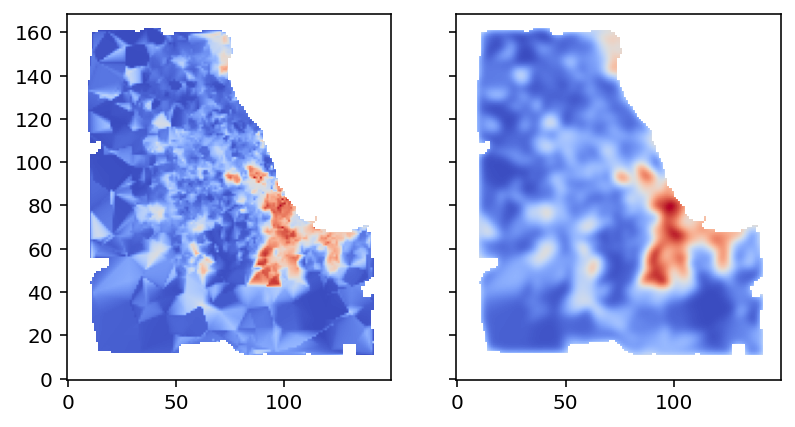

In [4]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
ax[0].imshow((ϕW - ϕB)[-1], origin="lower", cmap="coolwarm_r")
ax[1].imshow((ϕW_smooth - ϕB_smooth)[-1], origin='lower', cmap="coolwarm_r")

In [17]:
inferer = SociohydroInfer2D([ϕW_smooth],
                            [ϕB_smooth],
                            [np.unique(xx), np.unique(xx)],
                            [np.unique(yy), np.unique(yy)],
                            [np.array(years), np.array(years)],
                            t_dim = 0)

[Text(0.5, 1.0, '$\\partial_y \\phi_W$')]

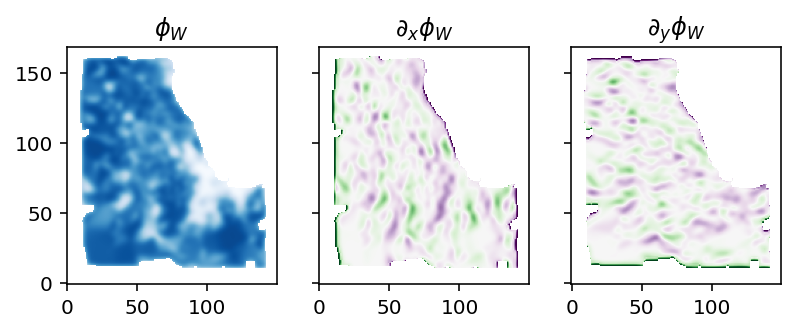

In [18]:
fig, ax = plt.subplots(1, 3, dpi=144, sharey=True)
ax[0].imshow(inferer.ABts[-1][..., -1, 0],
             origin="lower", vmin=0, vmax=1, cmap="Blues")
ax[0].set(title=r"$\phi_W$")
ax[1].imshow(inferer.differentiate(inferer.xs[-1], inferer.ABts[-1], order=1, periodic=False, axis=1)[..., -1, 0],
             origin="lower", vmin=-0.2, vmax=0.2, cmap="PRGn")
ax[1].set(title=r"$\partial_x \phi_W$")
ax[2].imshow(inferer.differentiate(inferer.ys[-1], inferer.ABts[-1], order=1, periodic=False, axis=0)[..., -1, 0],
             origin="lower", vmin=-0.2, vmax=0.2, cmap="PRGn")
ax[2].set(title=r"$\partial_y \phi_W$")

In [25]:
train_pct = 0.5
fitW, fitB, pW, pB = inferer.fit(train_pct)
print(pW)
print(pB)

-0.01427735598767649
0.155662593512865


In [27]:
fitB.coef_

array([-0.10787204,  0.60872534, -0.10781074,  0.57711828, -0.15142892,
       -0.37104706,  0.08970254])

Try to make inference take more than 1 field as input

In [51]:
datafiles = sorted(glob(os.path.join("/Users/danny/code/uchicago/sociohydro/data/raw/gridded", "*.hdf5")))
years = [1980, 1990, 2000, 2010, 2020]

ϕWs = []
ϕBs = []
xs = []
ys = []

for datafile in tqdm(datafiles):
    ϕW = []
    ϕB = []
    for year in years:
        w, b, xx, yy = get_data(datafile, year=year, region="all")
        ϕW.append(w)
        ϕB.append(b)

    ϕW = np.asarray(ϕW)
    ϕB = np.asarray(ϕB)
    xx /= 1000
    xs.append(np.unique(xx))
    yy /= 1000
    ys.append(np.unique(yy))

    # smooth
    ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW), 2.0, axes=[1, 2])
    ϕW_smooth[np.isnan(ϕW)] = np.nan
    ϕWs.append(ϕW_smooth)
    ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB), 2.0, axes=[1, 2])
    ϕB_smooth[np.isnan(ϕB)] = np.nan
    ϕBs.append(ϕB_smooth)

ts = [np.asarray(years)] * len(xs)

 89%|████████▉ | 34/38 [00:01<00:00, 38.77it/s]/Users/danny/code/uchicago/sociohydro/inference/infer_utils.py:67: RuntimeWarning: invalid value encountered in divide
  ϕW = white / (1.1 * capacity)
/Users/danny/code/uchicago/sociohydro/inference/infer_utils.py:68: RuntimeWarning: invalid value encountered in divide
  ϕB = black / (1.1 * capacity)
100%|██████████| 38/38 [00:01<00:00, 29.10it/s]


In [52]:
inferer = SociohydroInfer2D(ϕWs, ϕBs, xs, ys, ts,
                            t_dim = 0)

In [53]:
train_pct = 0.5
fitW, fitB, pW, pB = inferer.fit(train_pct)
print(pW)
print(pB)

-0.0019547959569683453
0.042974252808374205


It's bad, but it works!

# Test with ACS data

In [3]:
datafolder = "/project/vitelli/dsseara/schelling/data/yearly/raw/gridded"
datafiles = sorted(glob(os.path.join(datafolder, "*hdf5")))

In [4]:
def get_data(file, year=1990, region="all"):
    ykey = str(year)
    with h5py.File(file, "r") as d:
        x_grid = d[ykey]["x_grid"][()]
        y_grid = d[ykey]["y_grid"][()]
        capacity = np.zeros(x_grid.shape)
        if region == "county":
            white = d[ykey]["white_grid_county"][()]
            black = d[ykey]["black_grid_county"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_county"][:] + d[key]["black_grid_county"][:])
        elif region == "all":
            white = d[ykey]["white_grid_masked"][()]
            black = d[ykey]["black_grid_masked"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_masked"][:] + d[key]["black_grid_masked"][:])

    ϕW = white / (1.1 * capacity)
    ϕB = black / (1.1 * capacity)

    return ϕW, ϕB, x_grid, y_grid

In [9]:
σ = 2.0
ϕWs = []
ϕBs = []
xs = []
ys = []
ts = []
ts_interp = []

# LA, Fulton, Cook, Wayne, NYC, Harris
# idxs = [3, 14, 15, 18, 22, 33]
idxs = [15, 18, 22]
for idx in idxs:
    datafile = datafiles[idx]

    # get times and interp times
    with h5py.File(datafile, "r") as d:
        t = np.array([int(k) for k in list(d.keys())])
    t_interp = np.linspace(t[0], t[-1], 101)
    
    ϕW = []
    ϕB = []
    for year in t:
        w, b, xx, yy = get_data(datafile, year=year, region="all")
        ϕW.append(w)
        ϕB.append(b)

    # white demographic data
    ϕW = np.asarray(ϕW)
    ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW),
                                        σ, axes=[1, 2])
    cubicW = interpolate.interp1d(t, ϕW_smooth, axis=0, kind="cubic")
    ϕW_smooth_interp = cubicW(t_interp)
    ϕW_smooth_interp[:, np.any(np.isnan(ϕW), axis=0)] = np.nan
    ϕWs.append(ϕW_smooth_interp)

    # black demographic data
    ϕB = np.asarray(ϕB)
    ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB),
                                        σ, axes=[1, 2])
    cubicB = interpolate.interp1d(t, ϕB_smooth, axis=0, kind="cubic")
    ϕB_smooth_interp = cubicB(t_interp)
    ϕB_smooth_interp[:, np.any(np.isnan(ϕB), axis=0)] = np.nan
    ϕBs.append(ϕB_smooth_interp)

    # x position data
    xx /= 1000
    xs.append(np.unique(xx))

    # y position data
    yy /= 1000
    ys.append(np.unique(yy))

    # t data
    ts.append(t)
    ts_interp.append(t_interp)

Test interpolating in time

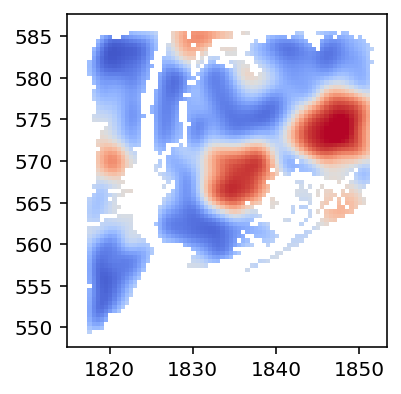

In [10]:
fig, ax = plt.subplots(dpi=144, figsize=(3, 3))
ax.set_aspect(1)

c = ax.pcolormesh(xs[2], ys[2], (ϕWs[2] - ϕBs[2])[0], cmap="coolwarm_r")

def animate(i):
    c.set_array((ϕWs[2] - ϕBs[2])[i].flatten())
    return [c,]

anim = animation.FuncAnimation(fig, animate, frames=len(ts_interp[0]),
                               interval=100, blit=True)

HTML(anim.to_html5_video())

In [11]:
inferer = SociohydroInfer2D(ϕWs, ϕBs,
                            xs, ys, ts_interp,
                            t_dim = 0)

IndexError: index 5 is out of bounds for axis 4 with size 5

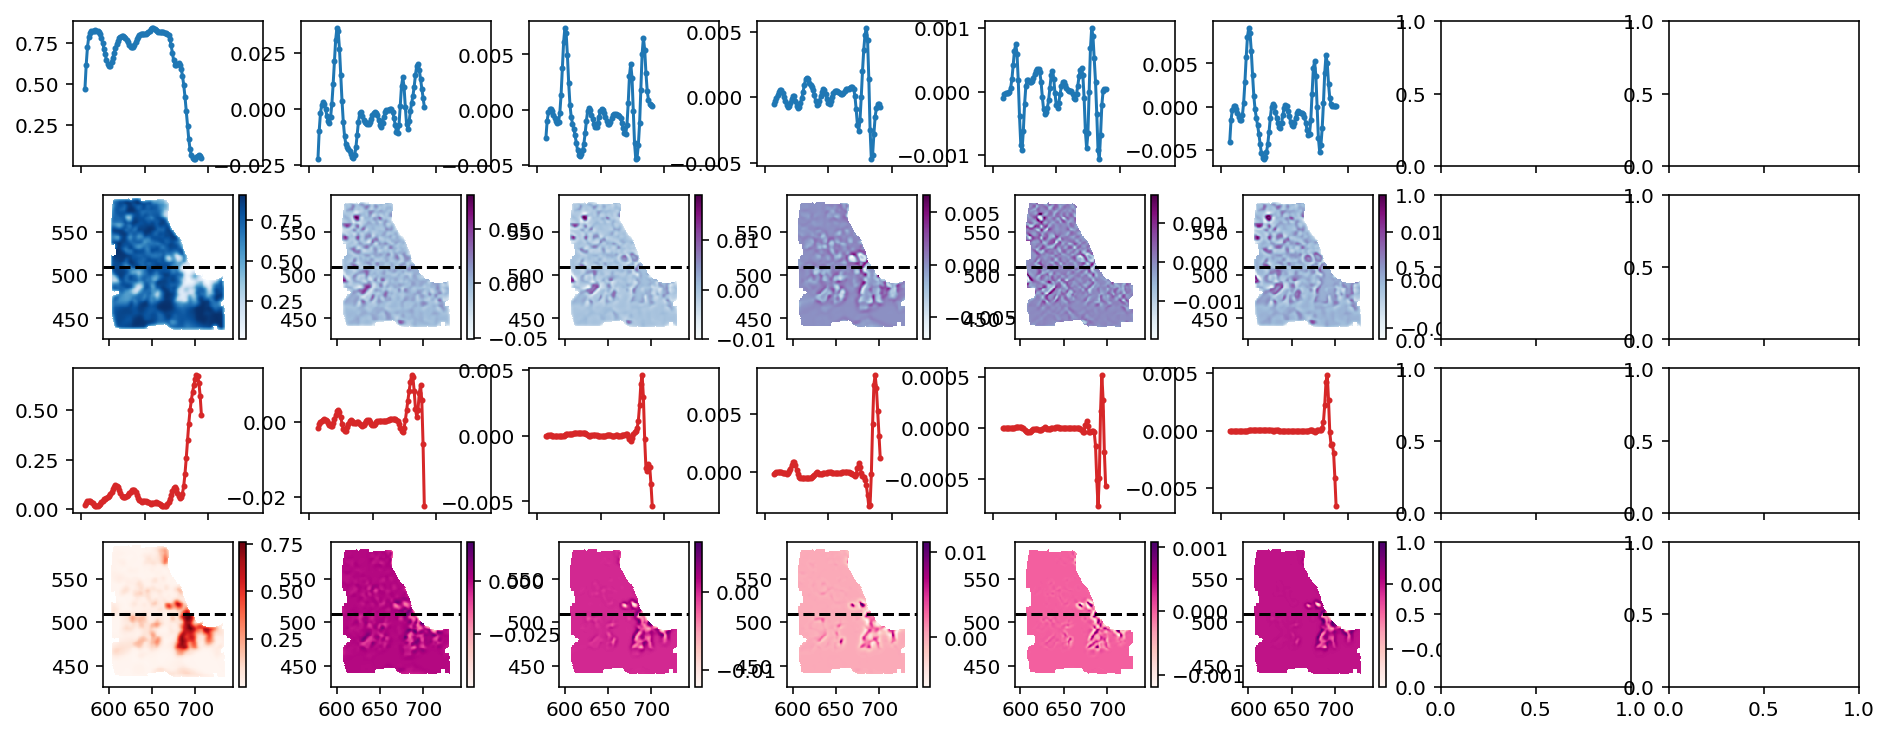

In [8]:
sc_idx = 1

features = inferer.calc_features(inferer.ABts[sc_idx], inferer.xs[sc_idx], inferer.ys[sc_idx])
fig, ax = plt.subplots(4, 8, dpi=144, figsize=(16,6),
                       sharex="col")

feat_max = np.nanmax(np.abs(features[..., -1, :, :]), axis=(0, 1))
midy = len(inferer.ys[sc_idx])//2

# plot White population
ax[0, 0].plot(inferer.xs[sc_idx], inferer.ABts[sc_idx][midy, :, -1, 0],
              "C0-o", ms=2)
f = ax[1, 0].pcolormesh(inferer.xs[sc_idx],
                        inferer.ys[sc_idx],
                        inferer.ABts[sc_idx][..., -1, 0],
                        cmap="Blues",
                        rasterized=True)
cax = ax[1, 0].inset_axes([1.05, 0, 0.05, 1])
fig.colorbar(f, cax=cax, ax=ax[1, 0])
ax[1, 0].axhline(inferer.ys[sc_idx][midy], color="k", ls="--")
ax[1, 0].set_aspect(1)

# plot Black population
ax[2, 0].plot(inferer.xs[sc_idx], inferer.ABts[sc_idx][midy, :, -1, 1],
              "C3-o", ms=2)
f = ax[3, 0].pcolormesh(inferer.xs[sc_idx],
                        inferer.ys[sc_idx],
                        inferer.ABts[sc_idx][..., -1, 1],
                        cmap="Reds",
                        rasterized=True)
cax = ax[3, 0].inset_axes([1.05, 0, 0.05, 1])
fig.colorbar(f, cax=cax, ax=ax[3, 0])
ax[3, 0].axhline(inferer.ys[sc_idx][midy], color="k", ls="--")
ax[3, 0].set_aspect(1)

for feat_idx in range(7):
    ax[0, feat_idx+1].plot(inferer.xs[sc_idx], features[midy, :, -1, 0, feat_idx],
                         "C0-o", ms=2)
    f = ax[1, feat_idx+1].pcolormesh(inferer.xs[sc_idx],
                                           inferer.ys[sc_idx],
                                           features[..., -1, 0, feat_idx],
                                           # vmin=-feat_max[group_idx, feat_idx],
                                           # vmax=+feat_max[group_idx, feat_idx],
                                           cmap="BuPu", rasterized=True)
    ax[1, feat_idx+1].set_aspect(1)
    cax = ax[1, feat_idx+1].inset_axes([1.05, 0, 0.05, 1])
    fig.colorbar(f, cax=cax, ax=ax[1, feat_idx+1])
    
    ax[1, feat_idx+1].axhline(inferer.ys[sc_idx][midy], color="k", ls="--")

    ax[2, feat_idx+1].plot(inferer.xs[sc_idx], features[midy, :, -1, 1, feat_idx],
                         "C3-o", ms=2)
    f = ax[3, feat_idx+1].pcolormesh(inferer.xs[sc_idx],
                                           inferer.ys[sc_idx],
                                           features[..., -1, 1, feat_idx],
                                           # vmin=-feat_max[group_idx, feat_idx],
                                           # vmax=+feat_max[group_idx, feat_idx],
                                           cmap="RdPu", rasterized=True)
    ax[3, feat_idx+1].set_aspect(1)
    cax = ax[3, feat_idx+1].inset_axes([1.05, 0, 0.05, 1])
    fig.colorbar(f, cax=cax, ax=ax[3, feat_idx+1])
    midy = len(inferer.ys[sc_idx])//2
    
    ax[3, feat_idx+1].axhline(inferer.ys[sc_idx][midy], color="k", ls="--")

ax[0, 0+1].set(title=r"$T$")
ax[0, 1+1].set(title=r"$k_{ii}$")
ax[0, 2+1].set(title=r"$k_{ij}$")
ax[0, 3+1].set(title=r"$\Gamma$")
ax[0, 4+1].set(title=r"$\nu_{iii}$")
ax[0, 5+1].set(title=r"$\nu_{iij}$")
ax[0, 6+1].set(title=r"$\nu_{ijj}$")

plt.tight_layout()

fig.savefig("/project/vitelli/dsseara/schelling/data/2024-06-05_inference/2024-06-26_features_Illinois_Cook_2021.pdf")

In [12]:
names = [r"$T$", r"$k_{ii}$", r"$k_{ij}$", r"$\Gamma$",
         r"$\nu_{iii}$", r"$\nu_{iij}$", r"$\nu_{ijj}$"]
coeffs = np.array([])
coeff_names = np.array([])
coeff_group = np.array([])
pWs = []
pBs = []

ntrials = 30
train_pct = 0.9
for trial in tqdm(range(ntrials)):
    fitW, fitB, pW, pB = inferer.fit(train_pct)
    coeffs = np.append(coeffs, list(fitW.coef_))
    coeffs = np.append(coeffs, list(fitB.coef_))
    coeff_names = np.append(coeff_names, names*2)
    coeff_group = np.append(coeff_group, ["W"]*len(fitW.coef_))
    coeff_group = np.append(coeff_group, ["B"]*len(fitW.coef_))
    pWs.append(pW)
    pBs.append(pB)


coef_df = pd.DataFrame({"val": coeffs,
                        "name": coeff_names,
                        "demo": coeff_group})

100%|██████████| 30/30 [04:43<00:00,  9.45s/it]


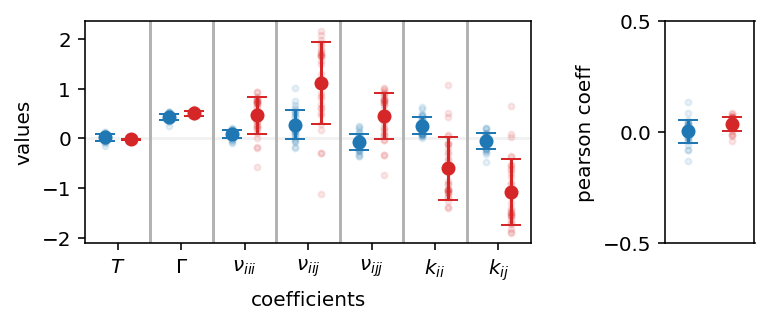

In [14]:
fig, ax = plt.subplots(dpi=144, figsize=(4,2))

for demo_code, color, offset in zip(["W", "B"], ["C0", "C3"], [-0.2, +0.2]):
    demo_df = coef_df.loc[coef_df["demo"]==demo_code][["val", "name"]]
    xvals = pd.Categorical(demo_df.name).codes+offset
    
    ax.plot(xvals, demo_df.val, ".", color=color, alpha=0.1)
    ax.errorbar(np.arange(7)+offset,
                demo_df.groupby("name").mean().reset_index().val.values,
                yerr=demo_df.groupby("name").std().reset_index().val.values,
                fmt="o", color=color, capsize=5)


ax.set(xticks=range(7), xticklabels=pd.Categorical(coef_df.name).categories.values,
       ylabel="values", xlabel="coefficients");
for n in range(1, len(coef_df.name.unique())):
    ax.axvline(n - 0.5, color="0.7")

ax.axhline(0, color="0.95", zorder=-1)


axp = ax.inset_axes([1.3, 0, 0.2, 1])
axp.plot([0] * len(pWs), pWs, "C0.", alpha=0.1)
axp.errorbar([0], np.mean(pWs), yerr=np.std(pWs),
             fmt="o", color="C0", capsize=5)
axp.plot([1] * len(pBs), pBs, "C3.", alpha=0.1)
axp.errorbar([1], np.mean(pBs), yerr=np.std(pBs),
             fmt="o", color="C3", capsize=5)
axp.set(xlim=[-0.5, 1.5], xticks=[],
        ylim=[-0.5, 0.5], yticks=[-0.5, 0, 0.5],
        ylabel="pearson coeff")

savefolder = "/project/vitelli/dsseara/schelling/data/2024-06-05_inference/"
# fig.savefig(os.path.join(savefolder, f"2024-06-27_coefficients_allFeatures_trainPct{train_pct}_sigma{σ}.pdf"),
#            bbox_inches="tight")

In [11]:
coef_df.groupby(["name", "demo"]).mean().reset_index()

,name,demo,val
0,$T$,B,0.092080
1,$T$,W,0.096690
2,$\Gamma$,B,0.474850
3,$\Gamma$,W,0.497152
4,$\nu_{iii}$,B,0.121735
5,$\nu_{iii}$,W,-0.006106
6,$k_{ii}$,B,-0.434879
7,$k_{ii}$,W,0.064444
8,$k_{ij}$,B,-0.361575
9,$k_{ij}$,W,-0.081779


In [12]:
coef_df.to_csv(os.path.join(savefolder, f"2024-06-27_coefficients_allFeatures_trainPct{train_pct}_sigma{σ}.csv"), index=False)
coef_df.groupby(["name", "demo"]).mean().reset_index().to_csv(os.path.join(savefolder, f"2024-06-27_coefficients_allFeatures_trainPct{train_pct}_sigma{σ}_mean.csv"),
                                                             index=False)